In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [6]:
generator = make_generator_model()
discriminator=make_discriminator_model()

In [7]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [8]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [9]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [10]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
   
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
 
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [11]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

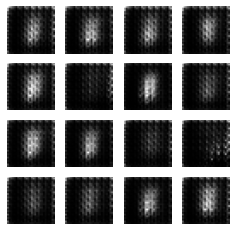

Time for epoch 1 is 14.199245691299438 sec


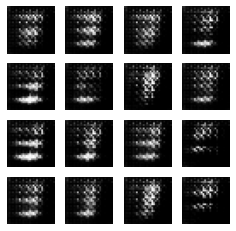

Time for epoch 2 is 6.383969783782959 sec


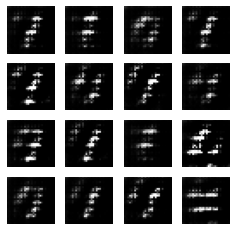

Time for epoch 3 is 6.2021708488464355 sec


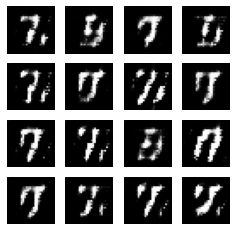

Time for epoch 4 is 6.215466260910034 sec


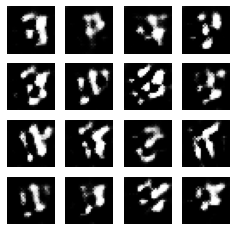

Time for epoch 5 is 6.3220860958099365 sec


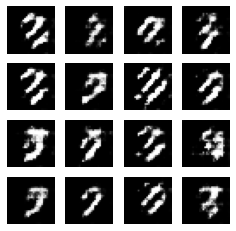

Time for epoch 6 is 6.175892114639282 sec


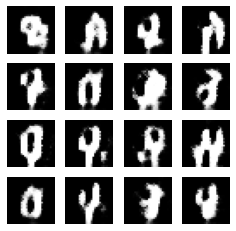

Time for epoch 7 is 6.191047430038452 sec


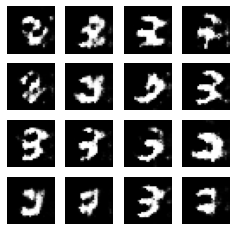

Time for epoch 8 is 6.322244167327881 sec


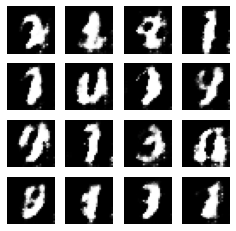

Time for epoch 9 is 6.197063207626343 sec


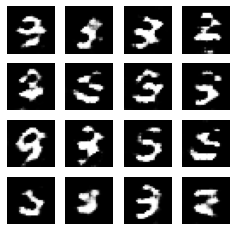

Time for epoch 10 is 6.330382347106934 sec


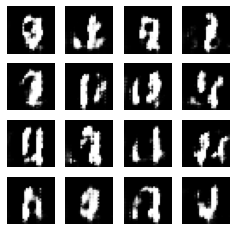

Time for epoch 11 is 6.188263416290283 sec


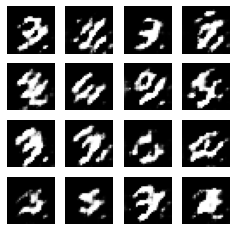

Time for epoch 12 is 6.183539628982544 sec


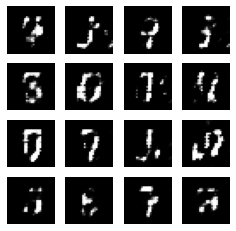

Time for epoch 13 is 6.347538471221924 sec


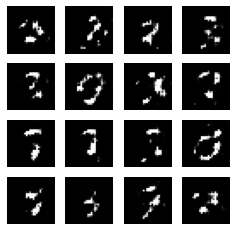

Time for epoch 14 is 6.1798179149627686 sec


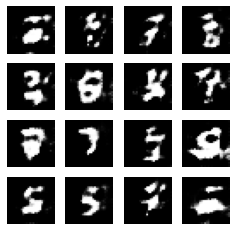

Time for epoch 15 is 6.286749362945557 sec


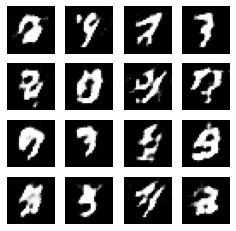

Time for epoch 16 is 6.328454494476318 sec


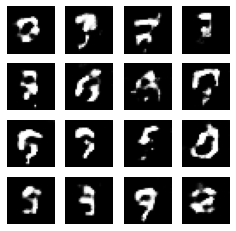

Time for epoch 17 is 6.191605806350708 sec


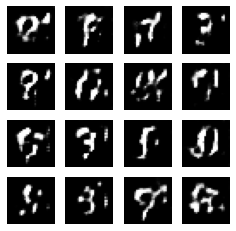

Time for epoch 18 is 6.190161466598511 sec


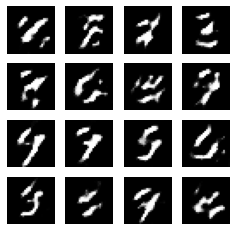

Time for epoch 19 is 6.3313915729522705 sec


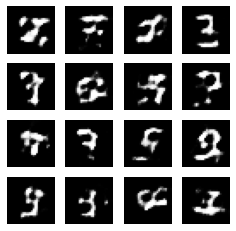

Time for epoch 20 is 6.211794376373291 sec


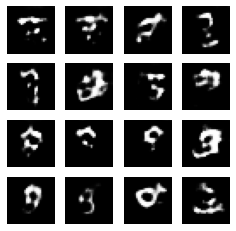

Time for epoch 21 is 6.183212757110596 sec


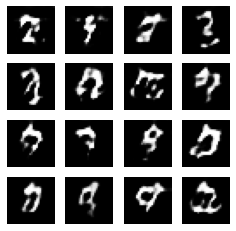

Time for epoch 22 is 6.340745210647583 sec


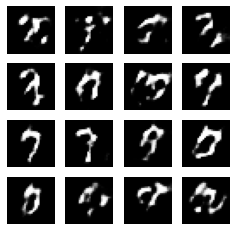

Time for epoch 23 is 6.192910671234131 sec


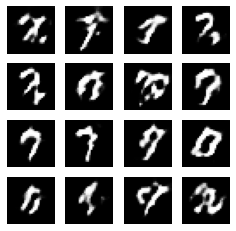

Time for epoch 24 is 6.185972213745117 sec


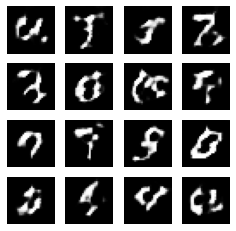

Time for epoch 25 is 6.334688663482666 sec


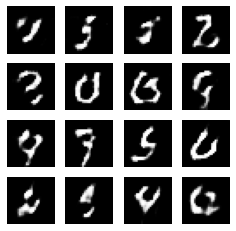

Time for epoch 26 is 6.198436975479126 sec


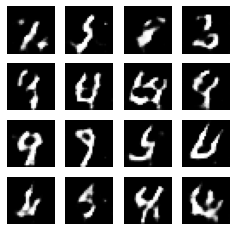

Time for epoch 27 is 6.1837310791015625 sec


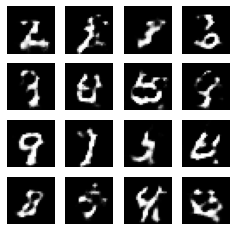

Time for epoch 28 is 6.328236818313599 sec


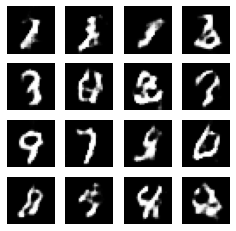

Time for epoch 29 is 6.198511362075806 sec


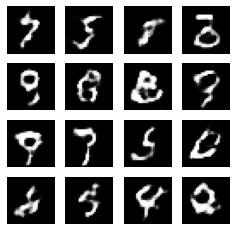

Time for epoch 30 is 6.2531516551971436 sec


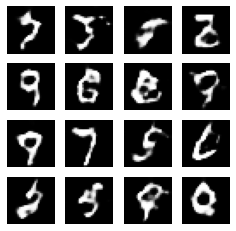

Time for epoch 31 is 6.3580687046051025 sec


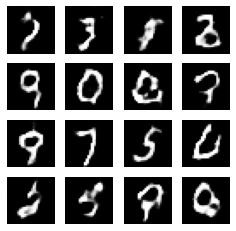

Time for epoch 32 is 6.1872334480285645 sec


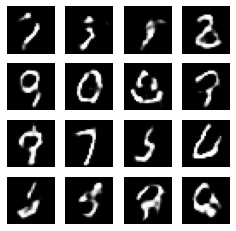

Time for epoch 33 is 6.200208902359009 sec


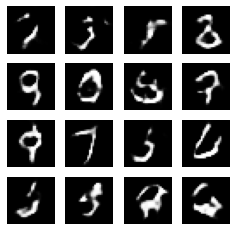

Time for epoch 34 is 6.355813980102539 sec


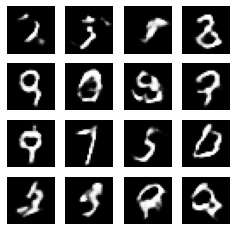

Time for epoch 35 is 6.187894582748413 sec


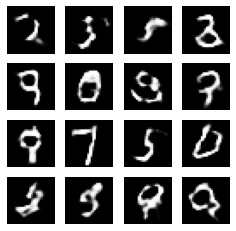

Time for epoch 36 is 6.198131799697876 sec


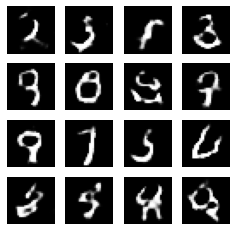

Time for epoch 37 is 6.351061105728149 sec


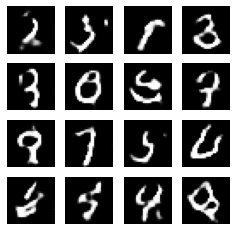

Time for epoch 38 is 6.21862006187439 sec


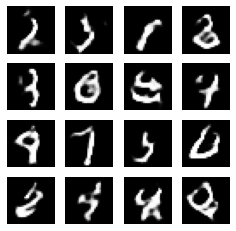

Time for epoch 39 is 6.189762115478516 sec


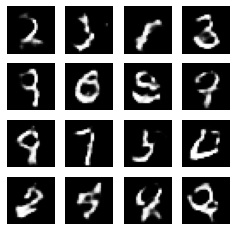

Time for epoch 40 is 6.344324588775635 sec


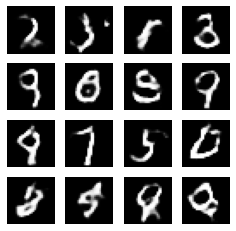

Time for epoch 41 is 6.211875677108765 sec


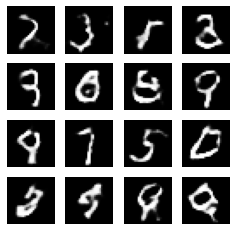

Time for epoch 42 is 6.220899820327759 sec


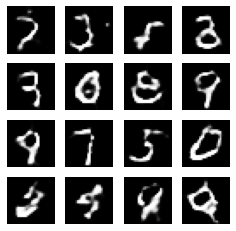

Time for epoch 43 is 6.381771802902222 sec


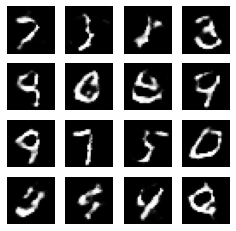

Time for epoch 44 is 6.208817481994629 sec


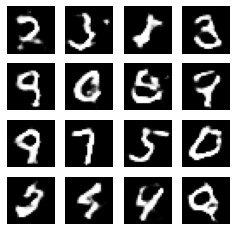

Time for epoch 45 is 6.28524374961853 sec


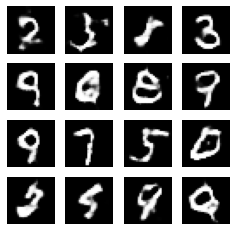

Time for epoch 46 is 6.356329441070557 sec


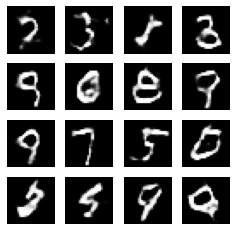

Time for epoch 47 is 6.209107160568237 sec


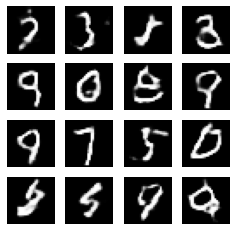

Time for epoch 48 is 6.233421325683594 sec


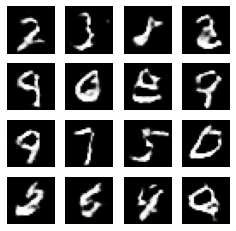

Time for epoch 49 is 6.368793725967407 sec


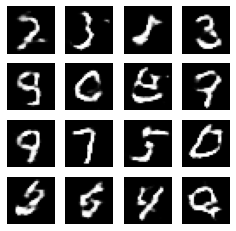

Time for epoch 50 is 6.203580141067505 sec


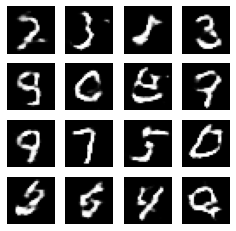

In [12]:
train(train_dataset, EPOCHS)

Reference - https://www.tensorflow.org/tutorials/generative/dcgan